In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [91]:
import chardet

# Detecter l'encodage du fichier
with open('/content/gdrive/Shareddrives/DA tools/RFM_CUSTOMER_PROFILING/OnlineRetail.csv', 'rb') as f:
    result = chardet.detect(f.read())
print(result)


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [93]:
data=pd.read_csv("/content/gdrive/Shareddrives/DA tools/RFM_CUSTOMER_PROFILING/OnlineRetail.csv",encoding='ISO-8859-1',delimiter=',')

#Analyse des données
print("Dataset dimention:", data.shape)
print("Dataset description:", data.describe)
print("Dataset description:", data.columns)


Dataset dimention: (541909, 8)
Dataset description: <bound method NDFrame.describe of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT     

In [94]:
#Données nulles?
data.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [95]:
#Suppression des valeurs nulles
data=data.dropna(subset=['CustomerID'])
print("Dataset dimention:", data.shape)
data.isnull().sum()

Dataset dimention: (406829, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [96]:
#Fréquence des prix
data["UnitPrice"].value_counts()

1.25      46555
1.65      37503
2.95      27211
0.85      26396
0.42      22032
          ...  
3.56          1
4.37          1
6.89          1
0.98          1
224.69        1
Name: UnitPrice, Length: 620, dtype: int64

In [112]:
#Doublons?
data.duplicated().sum()
#Suppression des doublons
data.drop_duplicates(inplace=True)
print("Dataset dimension:", data.shape)

Dataset dimension: (401604, 9)


In [113]:
#Définition des KPI

print(data['InvoiceDate'].dtype)
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
print(data['InvoiceDate'].dtype)
# Créer une nouvelle colonne pour le montant total de chaque transaction
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
rfm_data=data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (data['InvoiceDate'].max()-x.max()).days,
    "InvoiceNo":'count', #Frequency
    "TotalPrice": 'sum' # Monetary
})
rfm_data.columns = ['Recency', 'Frequency', 'Monetary']
rfm_data.head(10)

datetime64[ns]
datetime64[ns]


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,40,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
12352.0,73,95,1545.41
12353.0,204,4,89.00
12354.0,233,58,1079.40
12355.0,96,13,459.40


In [114]:
#Centrer et réduire les données
scaler=StandardScaler()
rfm_scaled=scaler.fit_transform(rfm_data)

In [115]:
#Trouver le K optimal de cluster avec la méthode elbow et le score de silhouette

elbow_scores = []
silhouette_scores = []

for n_clusters in range(2,10):
  kmeans= KMeans(n_clusters=n_clusters, random_state=42)
  kmeans.fit(rfm_scaled)
  elbow_scores.append(kmeans.inertia_)
  silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

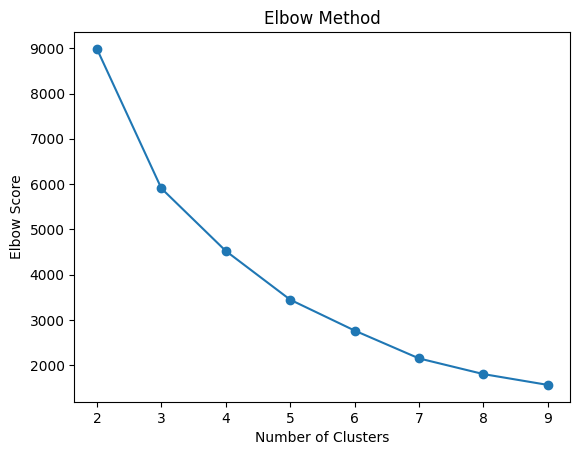

In [116]:
#Plots

#Plot Elbow
plt.plot(range(2,10), elbow_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Elbow Score')
plt.title('Elbow Method')
plt.show()

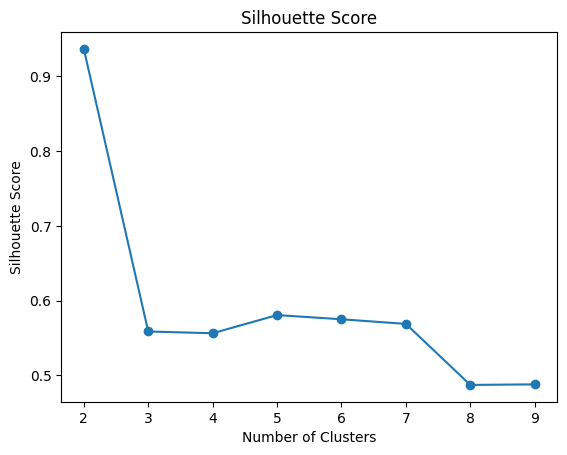

In [117]:
# Plot silhouette

plt.plot(range(2,10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

In [118]:
# Calculation of the optimal number of clusters


optimal_n_clusters = range(2,10)[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", optimal_n_clusters)

Optimal number of clusters: 2


In [119]:
# Running the K-means algorithm with the chosen number of clusters
kmeans=KMeans(n_clusters=2,random_state=42,n_init='auto')
kmeans.fit(rfm_scaled)

# Calculating the centres of mass of the various clusters
centroids=scaler.inverse_transform(kmeans.cluster_centers_)

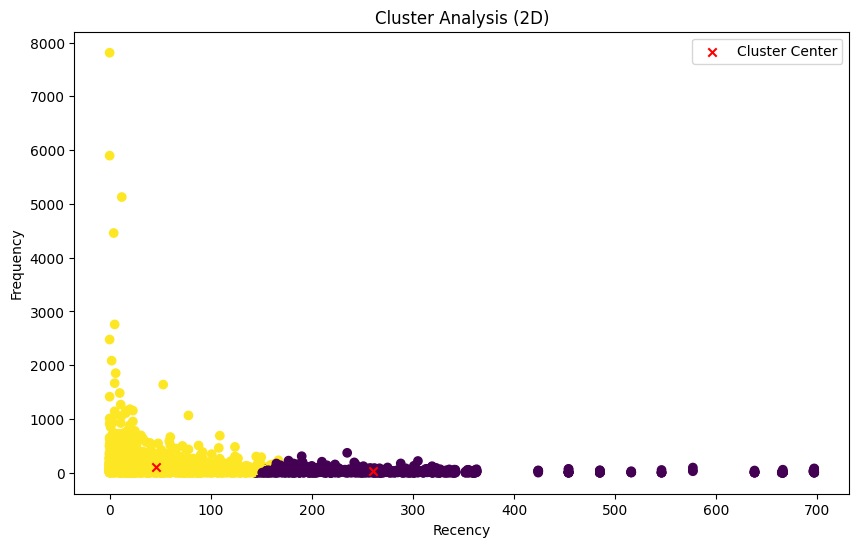

In [120]:
# Scatter plot of 2D results

plt.figure(figsize=(10,6))
plt.scatter(rfm_data['Recency'],rfm_data['Frequency'], c=kmeans.labels_,cmap='viridis')
plt.scatter(centroids[:,0],centroids[:,1], marker='x',c='red', label='Cluster Center')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Cluster Analysis (2D)')
plt.legend()
plt.show()

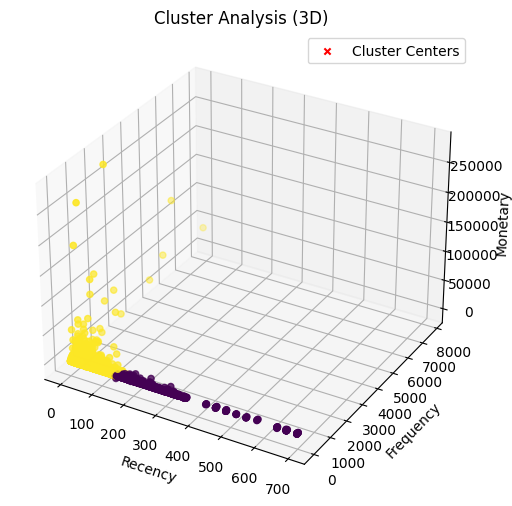

In [121]:
# Scatter plot of 3D results

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_data['Recency'], rfm_data['Frequency'], rfm_data['Monetary'], c=kmeans.labels_, cmap='viridis')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', c='red', label='Cluster Centers')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Cluster Analysis (3D)')
ax.legend()
plt.show()

In [122]:
# Distance of each data point from its centre

distances=kmeans.transform(rfm_scaled)
min_distances=np.min(distances, axis=1)

#Outliers
threshold= np.percentile(min_distances,95)
outliers=rfm_data[min_distances > threshold]
filtered_data=rfm_data[min_distances <= threshold]

n_outliers=len(outliers)
print("Number of outliers:",n_outliers)
print("Outliers:")
print(outliers)

Number of outliers: 219
Outliers:
            Recency  Frequency   Monetary
CustomerID                               
12415.0          25        778  123725.45
12433.0          10        420   13375.87
12441.0         485         11     173.55
12471.0           0        530   18705.52
12474.0           3        455    7064.77
...             ...        ...        ...
18109.0           4        451    7877.27
18113.0         546          1      76.32
18118.0          11       1268    5567.03
18119.0         516         29     180.70
18283.0          10        721    2045.53

[219 rows x 3 columns]


In [123]:
filtered_data.duplicated().sum()
filtered_data = filtered_data.reset_index(drop=True).drop_duplicates()

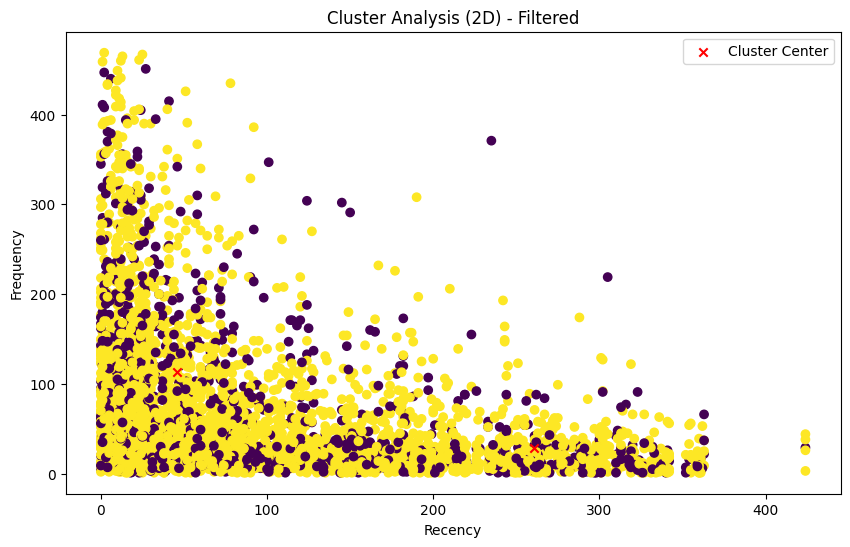

In [124]:
# Scatter plot of 2D results without outliers

plt.figure(figsize=(10,6))
plt.scatter(filtered_data['Recency'],filtered_data['Frequency'], c=kmeans.labels_[:len(filtered_data)],cmap='viridis')
plt.scatter(centroids[:,0],centroids[:,1], marker='x',c='red', label='Cluster Center')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Cluster Analysis (2D) - Filtered')
plt.legend()
plt.show()

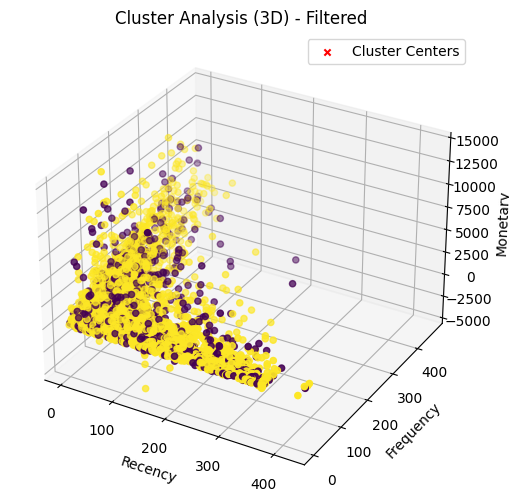

In [125]:
# Scatter plot of 3D results without outliers

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered_data['Recency'], filtered_data['Frequency'], filtered_data['Monetary'], c=kmeans.labels_[:len(filtered_data)], cmap='viridis')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', c='red', label='Cluster Centers')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Cluster Analysis (3D) - Filtered')
ax.legend()
plt.show()

**Conclusion:** Variables choisies sont non pertinentes pour le clustering. D'ouu la difficulté d'interprétation